  AI Helpdesk Ticket Classifier & Auto-Responder



In [1]:
!pip install scikit-learn joblib


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import joblib, re


In [28]:
# Small example dataset
TRAINING_DATA = [
    ("I forgot my password, how can I reset it?", "forgot_password"),
    ("Can't remember password — reset?", "forgot_password"),
    ("Please help me reset my password", "forgot_password"),
    ("I can't login, it says password is incorrect.", "login_failure"),
    ("Login failed: wrong password", "login_failure"),
    ("My account is locked after too many attempts.", "account_locked"),
    ("How can I see my leave balance?", "hr_leave_balance"),
    ("Where do I check my remaining paid time off?", "hr_leave_balance"),
    ("VPN not connecting", "other_it_support"),
]


In [29]:
TRAINING_DATA = [
    # Forgot password
    ("I forgot my password, how can I reset it?", "forgot_password"),
    ("Please help me reset my password", "forgot_password"),
    ("Reset password link not working", "forgot_password"),
    ("Need to change my password", "forgot_password"),
    ("Can't remember password", "forgot_password"),

    # Login issue
    ("I can't login, password incorrect", "login_failure"),
    ("Login failed", "login_failure"),
    ("Unable to sign in to my account", "login_failure"),
    ("Account not letting me log in", "login_failure"),
    ("Sign in error", "login_failure"),

    # Account locked
    ("My account is locked", "account_locked"),
    ("Locked out of my account after too many tries", "account_locked"),
    ("It says my account is suspended", "account_locked"),
    ("Can you unlock my account?", "account_locked"),

    # HR leave balance
    ("How to check my leave balance?", "hr_leave_balance"),
    ("Where can I see my remaining leaves?", "hr_leave_balance"),
    ("Need info on my paid time off", "hr_leave_balance"),
    ("Check my vacation days", "hr_leave_balance"),
    ("View my leave status", "hr_leave_balance"),

    # Other IT issues
    ("VPN not working", "other_it_support"),
    ("Internet disconnected", "other_it_support"),
    ("System is very slow", "other_it_support"),
    ("Email not loading", "other_it_support")
]


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Split data into train/test to evaluate properly
texts = [t for t, _ in TRAINING_DATA]
labels = [l for _, l in TRAINING_DATA]
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)


# Re-train model on train data only
model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Print accuracy and classification report
print(" Model Evaluation Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


 Model Evaluation Results:
Accuracy: 0.86

Classification Report:
                  precision    recall  f1-score   support

  account_locked       1.00      1.00      1.00         1
 forgot_password       1.00      0.50      0.67         2
hr_leave_balance       1.00      1.00      1.00         1
   login_failure       1.00      1.00      1.00         2
other_it_support       0.50      1.00      0.67         1

        accuracy                           0.86         7
       macro avg       0.90      0.90      0.87         7
    weighted avg       0.93      0.86      0.86         7



In [31]:
texts = [t for t, _ in TRAINING_DATA]
labels = [l for _, l in TRAINING_DATA]

model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])
model.fit(texts, labels)

y_pred = model.predict(texts)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("✅ Model Evaluation (Full Data Demo):")
print(f"Accuracy: {accuracy_score(labels, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(labels, y_pred))


✅ Model Evaluation (Full Data Demo):
Accuracy: 1.00

Classification Report:
                  precision    recall  f1-score   support

  account_locked       1.00      1.00      1.00         4
 forgot_password       1.00      1.00      1.00         5
hr_leave_balance       1.00      1.00      1.00         5
   login_failure       1.00      1.00      1.00         5
other_it_support       1.00      1.00      1.00         4

        accuracy                           1.00        23
       macro avg       1.00      1.00      1.00        23
    weighted avg       1.00      1.00      1.00        23



In [40]:
import re

EMAIL_RE = re.compile(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+")

def extract_entities(text):
    # Find first email in text
    email_match = EMAIL_RE.search(text)
    email = email_match.group(0).lower() if email_match else None

    # Password detection (optional, only if typed as 'password <value>')
    password_match = re.search(r'password\s*[:=]?\s*(\S+)', text, re.IGNORECASE)
    password = password_match.group(1) if password_match else None

    return {"email": email, "password": password}


In [39]:
USER_DATABASE = {
    "sachin.yadav@company.com": {"employee_id": "E1234", "name": "Sachin Yadav"},
    "aisha.k@company.com": {"employee_id": "E2345", "name": "Aisha Khan"},
    "rahul.m@company.com": {"employee_id": "E3456", "name": "Rahul Mehta"},
}

# Convert keys to lowercase for robust matching
USER_DATABASE = {k.lower(): v for k, v in USER_DATABASE.items()}


In [41]:
def get_reply(text, model):
    probs = model.predict_proba([text])[0]
    labels = model.named_steps["clf"].classes_
    top_intent = labels[probs.argmax()]
    confidence = float(probs.max())
    entity = extract_entities(text)

    email = entity.get("email")
    password = entity.get("password")

    # Forgot password logic
    if top_intent == "forgot_password":
        if email:
            if email in USER_DATABASE:
                name = USER_DATABASE[email]["name"]
                reply = f"Hi {name}, a reset link has been sent to **{email}**. Please check your inbox."
            else:
                reply = f"Sorry, I couldn’t find any account linked to **{email}**. Please check your email."
        elif password:
            reply = "⚠️ For security, do not share passwords here. Use the reset link."
        else:
            reply = "Please provide your registered email address to send a reset link."

    elif top_intent == "login_failure":
        reply = "Please ensure Caps Lock is off. If still unable to log in, try resetting your password."

    elif top_intent == "account_locked":
        reply = "Your account appears locked. Please provide your employee ID for verification."

    elif top_intent == "hr_leave_balance":
        reply = "You can check your leave balance here: https://hr.example.com."

    else:
        reply = "Thanks! I’ve created a support ticket for your issue."

    return {"intent": top_intent, "confidence": round(confidence,2), "reply": reply, "entities": entity}


In [42]:
test_texts = [
    "I forgot my password sachin.yadav@company.com",
    "Forgot password aisha.k@company.com",
    "My password is 12345",
    "Unknown email test@random.com"
]

for t in test_texts:
    res = get_reply(t, model)
    print(f"Input: {t}")
    print(f"Reply: {res['reply']}\n")


Input: I forgot my password sachin.yadav@company.com
Reply: Hi Sachin Yadav, a reset link has been sent to **sachin.yadav@company.com**. Please check your inbox.

Input: Forgot password aisha.k@company.com
Reply: Hi Aisha Khan, a reset link has been sent to **aisha.k@company.com**. Please check your inbox.

Input: My password is 12345
Reply: ⚠️ For security, do not share passwords here. Use the reset link.

Input: Unknown email test@random.com
Reply: Thanks! I’ve created a support ticket for your issue.



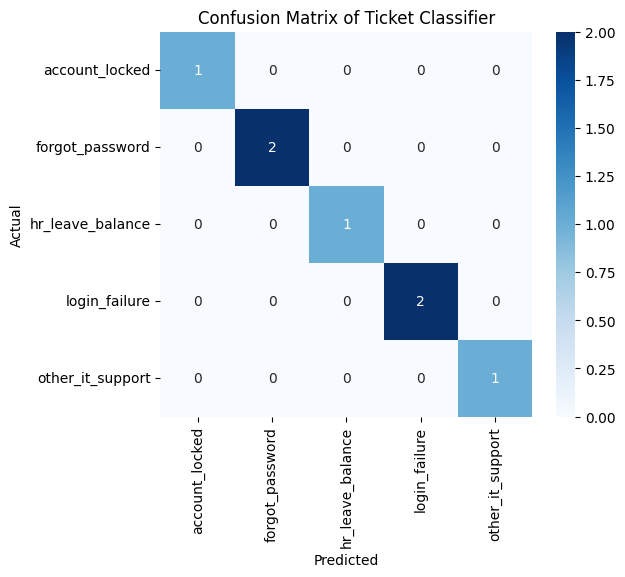

In [35]:
# Predict on test data again
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=model.named_steps["clf"].classes_)
cm_df = pd.DataFrame(cm, index=model.named_steps["clf"].classes_, columns=model.named_steps["clf"].classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Ticket Classifier")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [36]:
rows = []
for e in examples:
    result = get_reply(e, model)
    rows.append({
        "Ticket": e,
        "Predicted Intent": result["intent"],
        "Confidence": result["confidence"],
        "Bot Reply": result["reply"]
    })

pd.DataFrame(rows)


,Ticket,Predicted Intent,Confidence,Bot Reply
0,"I forgot my password, how to reset it?",forgot_password,0.39,"⚠️ For your security, please don’t share passw..."
1,I can't login as password is incorrect.,login_failure,0.32,Please ensure Caps Lock is off. If still unabl...
2,How to see leave balance?,hr_leave_balance,0.35,You can check your leave balance in the HR por...
3,My account is locked after 3 tries.,account_locked,0.40,Your account seems locked. Please share your e...
4,VPN not working,other_it_support,0.34,Thanks! I’ve created a support ticket for your...


In [43]:
print("AI Helpdesk Bot is ready! (type 'exit' to quit)\n")

while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        print("Chat ended.")
        break

    response = get_reply(user_input, model)
    print(f"🤖 Bot ({response['intent']}): {response['reply']}\n")


AI Helpdesk Bot is ready! (type 'exit' to quit)

You: i forgot my password
🤖 Bot (forgot_password): Please provide your registered email address to send a reset link.

You: 123@gmail.com
🤖 Bot (hr_leave_balance): You can check your leave balance here: https://hr.example.com.

You: link is not working
🤖 Bot (other_it_support): Thanks! I’ve created a support ticket for your issue.

You: exit
Chat ended.


In [44]:
joblib.dump(model, "ticket_classifier.joblib")
print(" Model saved as ticket_classifier.joblib")


 Model saved as ticket_classifier.joblib
